In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy.stats as stats
from scipy.optimize import minimize

# Set random seed for reproducibility
np.random.seed(42)

#-------------------------------------------------------
# 1. HISTORICAL METHOD
#-------------------------------------------------------

def historical_var(returns, alpha=0.05):
    """
    Calculate VaR using the historical method.
    
    Parameters:
    returns (array-like): Array of historical returns
    alpha (float): Confidence level (default: 0.05 for 95% confidence)
    
    Returns:
    float: Value at Risk at specified confidence level
    """
    returns_sorted = np.sort(returns)
    index = int(np.floor(len(returns) * alpha))
    return -returns_sorted[index]

def historical_cvar(returns, alpha=0.05):
    """
    Calculate CVaR using the historical method.
    
    Parameters:
    returns (array-like): Array of historical returns
    alpha (float): Confidence level (default: 0.05 for 95% confidence)
    
    Returns:
    float: Conditional Value at Risk at specified confidence level
    """
    var = historical_var(returns, alpha)
    return -np.mean(returns[returns <= -var])

#-------------------------------------------------------
# 2. PARAMETRIC METHOD (ASSUMING NORMAL DISTRIBUTION)
#-------------------------------------------------------

def parametric_var(returns, alpha=0.05):
    """
    Calculate VaR using the parametric method assuming normal distribution.
    
    Parameters:
    returns (array-like): Array of historical returns
    alpha (float): Confidence level (default: 0.05 for 95% confidence)
    
    Returns:
    float: Value at Risk at specified confidence level
    """
    mu = np.mean(returns)
    sigma = np.std(returns, ddof=1)
    return -(mu + sigma * stats.norm.ppf(alpha))

def parametric_cvar(returns, alpha=0.05):
    """
    Calculate CVaR using the parametric method assuming normal distribution.
    
    Parameters:
    returns (array-like): Array of historical returns
    alpha (float): Confidence level (default: 0.05 for 95% confidence)
    
    Returns:
    float: Conditional Value at Risk at specified confidence level
    """
    mu = np.mean(returns)
    sigma = np.std(returns, ddof=1)
    var = parametric_var(returns, alpha)
    z_score = stats.norm.ppf(alpha)
    return -(mu + sigma * stats.norm.pdf(z_score) / alpha)

#-------------------------------------------------------
# 3. MONTE CARLO METHOD
#-------------------------------------------------------

def monte_carlo_var(returns, n_simulations=10000, time_horizon=1, alpha=0.05):
    """
    Calculate VaR using Monte Carlo simulation.
    
    Parameters:
    returns (array-like): Array of historical returns
    n_simulations (int): Number of simulations to run
    time_horizon (int): Time horizon in days
    alpha (float): Confidence level (default: 0.05 for 95% confidence)
    
    Returns:
    float: Value at Risk at specified confidence level
    """
    mu = np.mean(returns)
    sigma = np.std(returns, ddof=1)
    
    # Generate random returns
    simulated_returns = np.random.normal(
        mu * time_horizon, 
        sigma * np.sqrt(time_horizon), 
        n_simulations
    )
    
    # Calculate VaR
    return -np.percentile(simulated_returns, alpha * 100)

def monte_carlo_cvar(returns, n_simulations=10000, time_horizon=1, alpha=0.05):
    """
    Calculate CVaR using Monte Carlo simulation.
    
    Parameters:
    returns (array-like): Array of historical returns
    n_simulations (int): Number of simulations to run
    time_horizon (int): Time horizon in days
    alpha (float): Confidence level (default: 0.05 for 95% confidence)
    
    Returns:
    float: Conditional Value at Risk at specified confidence level
    """
    mu = np.mean(returns)
    sigma = np.std(returns, ddof=1)
    
    # Generate random returns
    simulated_returns = np.random.normal(
        mu * time_horizon, 
        sigma * np.sqrt(time_horizon), 
        n_simulations
    )
    
    # Calculate VaR
    var = -np.percentile(simulated_returns, alpha * 100)
    
    # Calculate CVaR
    return -np.mean(simulated_returns[simulated_returns <= -var])

#-------------------------------------------------------
# SIMULATION AND VISUALIZATION
#-------------------------------------------------------

def run_simulation(returns, alpha=0.05):
    """
    Run all VaR and CVaR calculation methods and display results.
    
    Parameters:
    returns (array-like): Array of historical returns
    alpha (float): Confidence level (default: 0.05 for 95% confidence)
    
    Returns:
    DataFrame: Results of all calculations
    """
    methods = ['Historical', 'Parametric', 'Monte Carlo']
    var_results = [
        historical_var(returns, alpha),
        parametric_var(returns, alpha),
        monte_carlo_var(returns, alpha=alpha)
    ]
    cvar_results = [
        historical_cvar(returns, alpha),
        parametric_cvar(returns, alpha),
        monte_carlo_cvar(returns, alpha=alpha)
    ]
    
    results = pd.DataFrame({
        'Method': methods,
        f'VaR_{int((1-alpha)*100)}%': var_results,
        f'CVaR_{int((1-alpha)*100)}%': cvar_results
    })
    
    return results

def visualize_var_cvar(returns, alpha=0.05):
    """
    Visualize VaR and CVaR on a histogram of returns.
    
    Parameters:
    returns (array-like): Array of historical returns
    alpha (float): Confidence level (default: 0.05 for 95% confidence)
    """
    var = historical_var(returns, alpha)
    cvar = historical_cvar(returns, alpha)
    
    plt.figure(figsize=(12, 6))
    
    # Plot histogram
    plt.hist(returns, bins=50, density=True, alpha=0.6, color='skyblue')
    
    # Plot kernel density estimate
    x = np.linspace(min(returns), max(returns), 1000)
    kde = stats.gaussian_kde(returns)
    plt.plot(x, kde(x), 'r-', lw=2)
    
    # Plot VaR and CVaR lines
    plt.axvline(-var, color='black', linestyle='--', 
                label=f'Historical VaR {int((1-alpha)*100)}%: {var:.2%}')
    plt.axvline(-cvar, color='red', linestyle='--', 
                label=f'Historical CVaR {int((1-alpha)*100)}%: {cvar:.2%}')
    
    # Shade the area beyond VaR
    x_var = np.linspace(min(returns), -var, 1000)
    plt.fill_between(x_var, kde(x_var), alpha=0.3, color='red')
    
    plt.title('Distribution of Returns with VaR and CVaR')
    plt.xlabel('Returns')
    plt.ylabel('Density')
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    
    return plt

#-------------------------------------------------------
# EXAMPLE USAGE
#-------------------------------------------------------

def example_financial_portfolio():
    """Example calculation of VaR and CVaR for a financial portfolio."""
    # Generate some sample returns data (normally distributed for simplicity)
    np.random.seed(42)
    returns = np.random.normal(0.001, 0.02, 1000)  # 1000 days of returns
    
    # Calculate VaR and CVaR using different methods
    results = run_simulation(returns, alpha=0.05)
    print("\nFinancial Portfolio Risk Metrics (95% Confidence):")
    print(results)
    
    # Visualize the results
    plt = visualize_var_cvar(returns, alpha=0.05)
    plt.title('Financial Portfolio: Distribution of Returns with VaR and CVaR')
    plt.show()
    
    return results

#-------------------------------------------------------
# ENVIRONMENTAL RISK APPLICATIONS
#-------------------------------------------------------

def environmental_flood_risk():
    """
    Example of VaR and CVaR applied to flood damage costs.
    """
    # Simulate historical flood damage costs (in $ millions)
    np.random.seed(42)
    # Lognormal distribution is often used for modeling disaster damages
    flood_damages = np.random.lognormal(mean=1.5, sigma=1.2, size=1000)
    
    # Calculate VaR and CVaR for flood damages
    alpha = 0.05  # 95% confidence level
    results = run_simulation(flood_damages, alpha)
    print("\nFlood Damage Risk Metrics (95% Confidence):")
    print(results)
    
    # Visualize the results
    plt.figure(figsize=(12, 6))
    plt.hist(flood_damages, bins=50, density=True, alpha=0.6, color='lightblue')
    
    # Plot kernel density estimate
    x = np.linspace(0, max(flood_damages), 1000)
    kde = stats.gaussian_kde(flood_damages)
    plt.plot(x, kde(x), 'b-', lw=2)
    
    # Plot VaR and CVaR lines
    var = historical_var(flood_damages, alpha)
    cvar = historical_cvar(flood_damages, alpha)
    
    plt.axvline(var, color='black', linestyle='--', 
                label=f'Historical VaR {int((1-alpha)*100)}%: ${var:.2f}M')
    plt.axvline(cvar, color='red', linestyle='--', 
                label=f'Historical CVaR {int((1-alpha)*100)}%: ${cvar:.2f}M')
    
    # Shade the area beyond VaR
    x_var = np.linspace(var, max(flood_damages), 1000)
    plt.fill_between(x_var, kde(x_var), alpha=0.3, color='red')
    
    plt.title('Distribution of Annual Flood Damages with VaR and CVaR')
    plt.xlabel('Damage Cost ($ millions)')
    plt.ylabel('Density')
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()
    
    return results

def pollution_risk_analysis():
    """
    Example of VaR and CVaR applied to pollution emission exceedances.
    """
    # Simulate historical pollution exceedances (in tons above permitted level)
    np.random.seed(43)
    # Using a mixture of normal distributions to model both routine and extreme events
    routine_exceedances = np.random.normal(5, 3, 900)  # routine exceedances
    extreme_exceedances = np.random.normal(25, 10, 100)  # extreme events
    pollution_exceedances = np.concatenate([routine_exceedances, extreme_exceedances])
    
    # Calculate VaR and CVaR for pollution exceedances
    alpha = 0.05  # 95% confidence level
    results = run_simulation(pollution_exceedances, alpha)
    print("\nPollution Exceedance Risk Metrics (95% Confidence):")
    print(results)
    
    # Visualize the results
    plt.figure(figsize=(12, 6))
    plt.hist(pollution_exceedances, bins=50, density=True, alpha=0.6, color='lightgreen')
    
    # Plot kernel density estimate
    x = np.linspace(min(pollution_exceedances), max(pollution_exceedances), 1000)
    kde = stats.gaussian_kde(pollution_exceedances)
    plt.plot(x, kde(x), 'g-', lw=2)
    
    # Plot VaR and CVaR lines
    var = historical_var(pollution_exceedances, alpha)
    cvar = historical_cvar(pollution_exceedances, alpha)
    
    plt.axvline(var, color='black', linestyle='--', 
                label=f'Historical VaR {int((1-alpha)*100)}%: {var:.2f} tons')
    plt.axvline(cvar, color='red', linestyle='--', 
                label=f'Historical CVaR {int((1-alpha)*100)}%: {cvar:.2f} tons')
    
    # Shade the area beyond VaR
    x_var = np.linspace(var, max(pollution_exceedances), 1000)
    plt.fill_between(x_var, kde(x_var), alpha=0.3, color='red')
    
    plt.title('Distribution of Pollution Exceedances with VaR and CVaR')
    plt.xlabel('Exceedance Amount (tons)')
    plt.ylabel('Density')
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()
    
    return results

def drought_severity_risk():
    """
    Example of VaR and CVaR applied to drought severity.
    """
    # Simulate drought severity indices (negative values indicate more severe drought)
    np.random.seed(44)
    # Use a skewed distribution to model drought severity
    drought_severity = -np.abs(np.random.normal(0, 2, 1000))
    
    # Calculate VaR and CVaR for drought severity
    alpha = 0.05  # 95% confidence level
    results = run_simulation(drought_severity, alpha)
    print("\nDrought Severity Risk Metrics (95% Confidence):")
    print(results)
    
    # Visualize the results
    plt.figure(figsize=(12, 6))
    plt.hist(drought_severity, bins=50, density=True, alpha=0.6, color='tan')
    
    # Plot kernel density estimate
    x = np.linspace(min(drought_severity), max(drought_severity), 1000)
    kde = stats.gaussian_kde(drought_severity)
    plt.plot(x, kde(x), 'brown', lw=2)
    
    # Plot VaR and CVaR lines
    var = historical_var(drought_severity, alpha)
    cvar = historical_cvar(drought_severity, alpha)
    
    plt.axvline(-var, color='black', linestyle='--', 
                label=f'Historical VaR {int((1-alpha)*100)}%: {var:.2f}')
    plt.axvline(-cvar, color='red', linestyle='--', 
                label=f'Historical CVaR {int((1-alpha)*100)}%: {cvar:.2f}')
    
    # Shade the area beyond VaR
    x_var = np.linspace(min(drought_severity), -var, 1000)
    plt.fill_between(x_var, kde(x_var), alpha=0.3, color='red')
    
    plt.title('Distribution of Drought Severity Index with VaR and CVaR')
    plt.xlabel('Drought Severity Index')
    plt.ylabel('Density')
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()
    
    return results

#-------------------------------------------------------
# OPTIMIZATION WITH CVaR
#-------------------------------------------------------

def cvar_portfolio_optimization(returns, alpha=0.05, target_return=None):
    """
    Optimize a portfolio to minimize CVaR.
    
    Parameters:
    returns (DataFrame): DataFrame of asset returns
    alpha (float): Confidence level (default: 0.05 for 95% confidence)
    target_return (float): Target portfolio return (if None, finds minimum CVaR portfolio)
    
    Returns:
    dict: Dictionary containing optimal weights and risk metrics
    """
    n_assets = returns.shape[1]
    
    # Function to calculate negative CVaR (for minimization)
    def neg_cvar(weights):
        portfolio_returns = returns.dot(weights)
        return -historical_cvar(portfolio_returns, alpha)
    
    # Function to calculate portfolio return
    def portfolio_return(weights):
        return np.sum(returns.mean() * weights)
    
    # Constraints
    constraints = [{'type': 'eq', 'fun': lambda x: np.sum(x) - 1}]  # weights sum to 1
    
    if target_return is not None:
        constraints.append({'type': 'eq', 'fun': lambda x: portfolio_return(x) - target_return})
    
    # Bounds for weights (no short selling)
    bounds = tuple((0, 1) for _ in range(n_assets))
    
    # Initial guess (equal weights)
    initial_weights = np.ones(n_assets) / n_assets
    
    # Optimize
    result = minimize(neg_cvar, initial_weights, method='SLSQP', bounds=bounds, constraints=constraints)
    
    if not result.success:
        print("Optimization failed:", result.message)
    
    optimal_weights = result.x
    
    # Calculate metrics for the optimal portfolio
    portfolio_returns = returns.dot(optimal_weights)
    var = historical_var(portfolio_returns, alpha)
    cvar = historical_cvar(portfolio_returns, alpha)
    mean_return = portfolio_return(optimal_weights)
    
    return {
        'weights': optimal_weights,
        'var': var,
        'cvar': cvar,
        'mean_return': mean_return,
        'success': result.success
    }

# Run examples if this script is executed directly
#if __name__ == "__main__":
#    example_financial_portfolio()
#    environmental_flood_risk()
#    pollution_risk_analysis()
#    drought_severity_risk()


Financial Portfolio Risk Metrics (95% Confidence):
        Method   VaR_95%  CVaR_95%
0   Historical  0.029511  0.037383
1   Parametric  0.030827 -0.041783
2  Monte Carlo  0.031175  0.039518


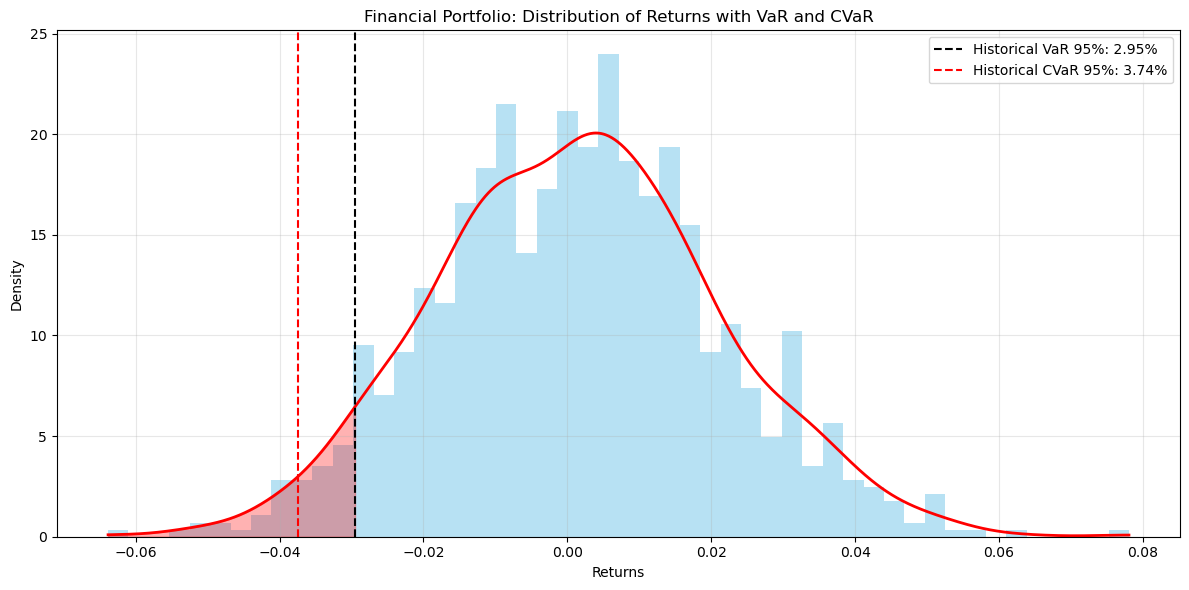

,Method,VaR_95%,CVaR_95%
0,Historical,0.029511,0.037383
1,Parametric,0.030827,-0.041783
2,Monte Carlo,0.031175,0.039518


In [2]:
# Run examples if this script is executed directly
#if __name__ == "__main__":
example_financial_portfolio()
#environmental_flood_risk()
#pollution_risk_analysis()
#drought_severity_risk()


Flood Damage Risk Metrics (95% Confidence):
        Method    VaR_95%   CVaR_95%
0   Historical  -0.718471  -0.482191
1   Parametric  23.428612 -50.822915
2  Monte Carlo  23.784493  32.316381


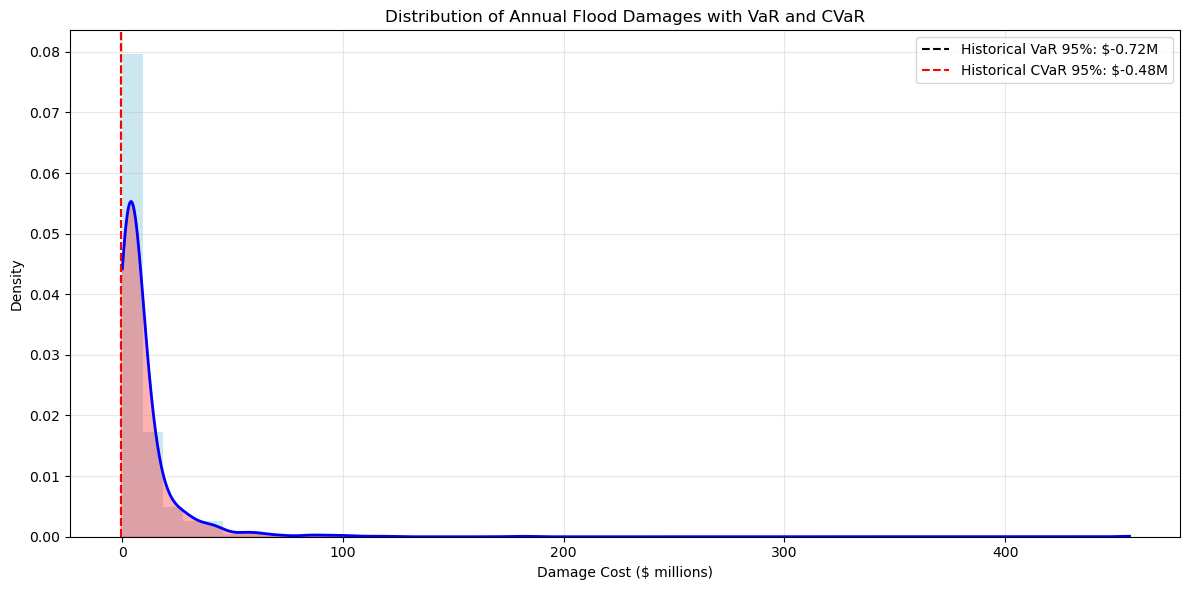

,Method,VaR_95%,CVaR_95%
0,Historical,-0.718471,-0.482191
1,Parametric,23.428612,-50.822915
2,Monte Carlo,23.784493,32.316381


In [3]:
environmental_flood_risk()


Pollution Exceedance Risk Metrics (95% Confidence):
        Method   VaR_95%   CVaR_95%
0   Historical -0.097904   1.035498
1   Parametric  5.224006 -22.451525
2  Monte Carlo  5.242921   8.582089


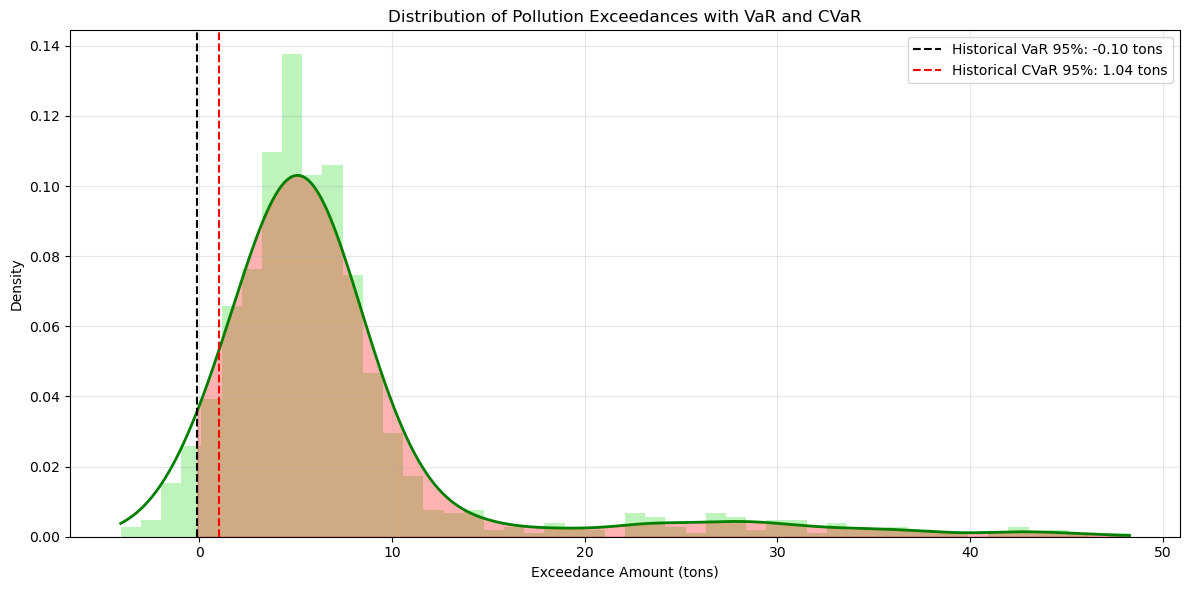

,Method,VaR_95%,CVaR_95%
0,Historical,-0.097904,1.035498
1,Parametric,5.224006,-22.451525
2,Monte Carlo,5.242921,8.582089


In [4]:
pollution_risk_analysis()


Drought Severity Risk Metrics (95% Confidence):
        Method   VaR_95%  CVaR_95%
0   Historical  3.857926  4.732006
1   Parametric  3.588343 -0.892340
2  Monte Carlo  3.595522  4.084216


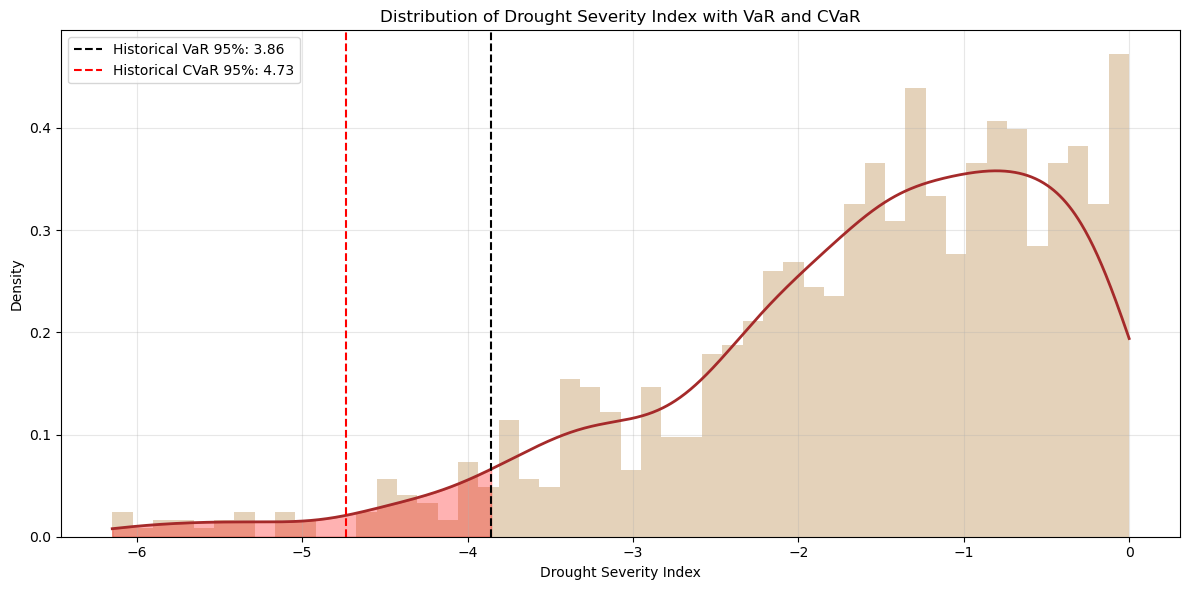

,Method,VaR_95%,CVaR_95%
0,Historical,3.857926,4.732006
1,Parametric,3.588343,-0.892340
2,Monte Carlo,3.595522,4.084216


In [5]:
drought_severity_risk()